# Belarus Used Car Market

### Introduction

Your cousin Vladimir is interested in opening a used car dealership in Belarus. Vladimir considers himself to be very attuned with the used vehicle industry, however he would like to have his preconceptions supported by data if he his going to open a business. 

Your cousin has a limitited amount of space on the lot so he needs to be selective about which vehicles he is selling in order to maximize sales for the business. He is asking if you could build a report which dissects the total sales figures of the used vehicle market so he can identify which type(s) of vehicle are acceptable to sell. He is also asking if you could construct a simple model to predict a rough estimate of car prices to help future employees establish pricing 

Knowing you are a proficitent data analyst,he has provided you with a dataset comprising of all used cars sold in Belarus during 2019. 

The goals of this workbook are as follows:
- identify key trends within the used vehicle market
- determine if a Multiple Linear Regression model is suitable to predict price  



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

data = pd.read_csv("C:/Users/clayt/OneDrive/Documents/Data Analysis/Jupyter Notebook projects/Cars_clean data.csv")
cars = pd.DataFrame(data)

### 1.0 - Data Exploration

In [2]:
cars.head(10)

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,price_usd,is_exchangeable
0,Subaru,Outback,automatic,silver,190000,2010,gasoline,False,gasoline,2.5,universal,False,owned,all,10900.00,False
1,Subaru,Outback,automatic,blue,290000,2002,gasoline,False,gasoline,3.0,universal,False,owned,all,5000.00,True
2,Subaru,Forester,automatic,red,402000,2001,gasoline,False,gasoline,2.5,suv,False,owned,all,2800.00,True
3,Subaru,Impreza,mechanical,blue,10000,1999,gasoline,False,gasoline,3.0,sedan,False,owned,all,9999.00,True
4,Subaru,Legacy,automatic,black,280000,2001,gasoline,False,gasoline,2.5,universal,False,owned,all,2134.11,True
5,Subaru,Outback,automatic,silver,132449,2011,gasoline,False,gasoline,2.5,universal,False,owned,all,14700.00,True
6,Subaru,Forester,automatic,black,318280,1998,gasoline,False,gasoline,2.5,universal,False,owned,all,3000.00,True
7,Subaru,Legacy,automatic,silver,350000,2004,gasoline,False,gasoline,2.5,sedan,False,owned,all,4500.00,False
8,Subaru,Outback,automatic,grey,179000,2010,gasoline,False,gasoline,2.5,universal,False,owned,all,12900.00,False
9,Subaru,Forester,automatic,silver,571317,1999,gasoline,False,gasoline,2.5,universal,False,owned,all,4200.00,True


### 1.1 - Summary Statistics
Please uncomment summary command(s) below and run cell to retreive desired summary statistic(s)


In [3]:
#cars.shape
#cars.info()
#cars.nunique()
#cars.describe()
#cars.isnull().sum()

 * There are 38,531 rows and 16 columns
 * There data types for the 16 variables are 9 string, 3 boolean, 2 float(64), and 2 int64
 * Data is relatively clean with engine_capacity having only 10 missing values
 * Some categorical variables have high cardinality (manufacturer_name and model_name with 55 and 1118 dimensions respectively)
 * Mean price of a vehicle is \\$6,639.97 USD with a standard deviation of \\$6,425.15 USD     

### 1.2 - Cleaning Data - Replacing Null Values

In [4]:
cars[cars.engine_capacity.isnull()].index
cars.iloc[[8782, 9048, 24226, 25943, 26203, 26222, 26582, 26914, 27554, 29590],]

# We can see that the 10 missing data values are missing for good reason. Engine capacity of NaN corresponds to electric vehicles. 

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,price_usd,is_exchangeable
8782,Fiat,500,automatic,orange,27000,2013,electric,False,electric,NaN,hatchback,False,owned,front,14900.0,True
9048,Fiat,500,automatic,orange,49000,2014,electric,False,electric,NaN,hatchback,False,owned,front,16000.0,False
24226,Chevrolet,Volt,automatic,silver,168000,2013,electric,False,electric,NaN,liftback,False,owned,front,12950.0,True
25943,Nissan,Leaf,automatic,white,57357,2015,electric,False,electric,NaN,hatchback,False,owned,front,13850.0,False
26203,Nissan,Leaf,automatic,blue,97400,2011,electric,False,electric,NaN,hatchback,False,owned,front,9300.0,True
26222,Nissan,Leaf,automatic,white,50000,2014,electric,False,electric,NaN,hatchback,False,owned,front,12900.0,False
26582,Nissan,Leaf,automatic,black,84000,2014,electric,False,electric,NaN,hatchback,False,owned,front,14500.0,False
26914,Nissan,Leaf,automatic,black,84500,2013,electric,False,electric,NaN,hatchback,False,owned,front,15500.0,False
27554,BMW,i3,automatic,white,54150,2015,electric,False,electric,NaN,hatchback,False,owned,rear,24750.0,True
29590,BMW,i3,automatic,other,67000,2018,electric,False,electric,NaN,liftback,False,owned,rear,39999.0,False


This raises the question of if we should treat engine_capacity as numerical or categorical. In reality there are a finite amount of engine sizes with manufactures sharing engines between various models. However there are 61 different engine sizes which would lead to a large number of dummy variables and not suitable for Multiple Linear Regression

For now, let's replace all NaN with 0.0 to reduce errors when initially analyzing the data, but when constructing the model we should group into bins to create a limited number of dummy variables. One bin should be engine_capacity = 0.0 to identify electric vehicles exclusively 

In [5]:
# Replace NaN with 0.0 for now

cars.engine_capacity.fillna(0.0,inplace =True)

### 1.3 - Data Visualization

Let's take an initial glimpse of the numeric and categorical variable distribution

### 1.3.1 -  Histograms of Numerical Variables

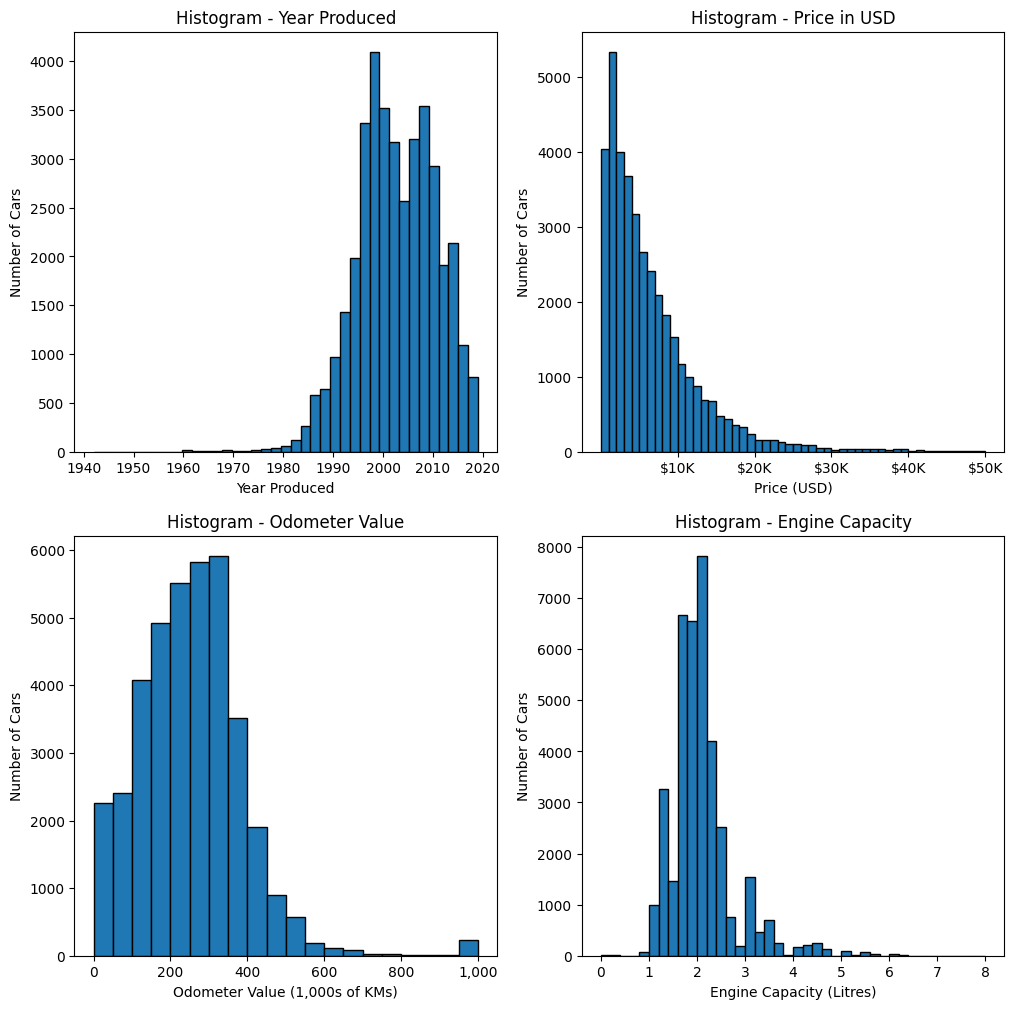

In [6]:
fig, axs = plt.subplots(2,2, figsize =(12,12))

bins_year_produced = int(((cars.year_produced.max() - cars.year_produced.min()) + 1)/2)
axs[0,0].hist(cars.year_produced, bins =bins_year_produced, edgecolor = "black")
axs[0,0].set_title("Histogram - Year Produced")
axs[0,0].set_xlabel("Year Produced")
axs[0,0].set_ylabel("Number of Cars")


axs[0,1].hist(cars.price_usd, bins = 50, edgecolor = "black")
axs[0,1].set_title("Histogram - Price in USD")
axs[0,1].set_xticks([10000,20000,30000,40000,50000],["$10K", "$20K", "$30K", "$40K", "$50K"])
axs[0,1].set_xlabel("Price (USD)")
axs[0,1].set_ylabel("Number of Cars")


axs[1,0].hist(cars.odometer_value, bins = 20, edgecolor= "black")
axs[1,0].set_title("Histogram - Odometer Value")
axs[1,0].set_xticks([0,200000,400000,600000,800000,1000000],["0", "200", "400","600","800", "1,000"])
axs[1,0].set_xlabel("Odometer Value (1,000s of KMs)")
axs[1,0].set_ylabel("Number of Cars")

axs[1,1].hist(cars.engine_capacity, bins = 40,edgecolor = "black")
axs[1,1].set_title("Histogram - Engine Capacity")
axs[1,1].set_xlabel("Engine Capacity (Litres)")
axs[1,1].set_ylabel("Number of Cars");                   


### 1.3.2 - Visualization of Categorical Variables

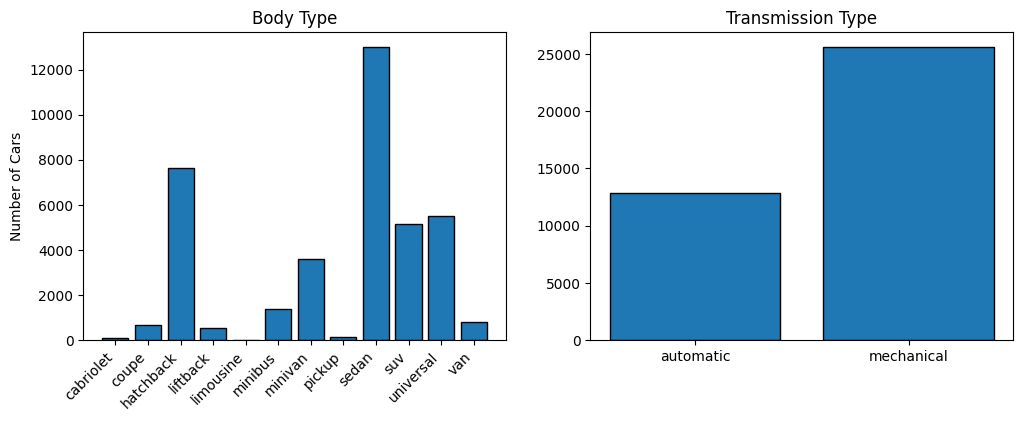

In [7]:
# Create x and y series of Body Type for .bar
body_type_grouped = cars.groupby("body_type").body_type.value_counts()
x_bt = body_type_grouped.index
y_bt = body_type_grouped.values

# Create x and y series of Tranmission Type for .bar
transmission_grouped = cars.groupby("transmission").transmission.value_counts()
x_transmission = transmission_grouped.index
y_transmission = transmission_grouped.values


fig, axs = plt.subplots(1,2,figsize =(12,4))

axs[0].bar(x_bt,y_bt, edgecolor = "black")
axs[0].set_title("Body Type")
axs[0].set_ylabel("Number of Cars")
axs[0].set_xticks(x_bt)
axs[0].set_xticklabels(x_bt,rotation = 45, ha = "right");

axs[1].bar(x_transmission, y_transmission, edgecolor= "black")
axs[1].set_title("Transmission Type");

### 1.4 - Feature Addition

We will add the following features to our data set
* manufacturer_region --> (Asia,Europe, North America)
* vehicle_class ->(Budget, Economy, Luxury) 

### 1.4.1 - Feature Addition (Manufacturer Region)

A common measure used across the vehicle industry is to classify cars by the geographical region with which the manufacturer is based. For buyers and sellers alike, doing so implies various traits typical of vehicles from the region.
 
Buyers often associate characteristics such as quality, reputation, and resale value to the region the car is from, while it is important for sellers to have this information in a database to keep track of the tarifs/import taxes of vehicles from different countries. As a buyer and a seller of used vehicles, Vladimir would find this information insightful and would be able to make more educated decisions for his business

To improve upon the dataset, let's add a variable that identifies which broad geographic region the vehicle is originates (**Europe**, **Asia**, **North America**)

#### Create "manufacturer_region" feature

In [8]:
# Create a dictionary to identify which country each manufacturer originates 

manufacturer_dictionary = {
    "Volkswagen": "Euro",
    "Opel": "Euro",
    "BMW":"Euro",
    "Ford": "N. America",
    "Renault": "Euro",
    "Audi": "Euro",
    "Mercedes-Benz": "Euro",
    "Peugeot":"Euro",
    "Citroen":"Euro",
    "Nissan": "Asia",
    "Mazda": "Asia",
    "Toyota":"Asia",
    "Hyundai":"Asia",
    "Skoda":"Euro",
    "Kia":"Asia",
    "Mitsubishi":"Asia",
    "Fiat":"Euro",
    "Honda":"Asia",
    "Volvo":"Euro",
    "ВАЗ":"Euro",
    "Chevrolet":"N. America",
    "Chrysler":"N. America",
    "Seat": "Euro",
    "Dodge": "N. America",
    "Subaru":"Asia",
    "Rover":"Euro",
    "Suzuki":"Asia",
    "Daewoo":"Asia",
    "Lexus":"Asia",
    "Alfa Romeo": "Euro",
    "ГАЗ":"Euro",
    "Land Rover": "Euro",
    "Infiniti":"Asia",
    "LADA":"Euro",
    "Iveco": "Euro",
    "Saab": "Euro",
    "Jeep": "N. America",
    "Lancia": "Euro",
    "SsangYong": "Asia",
    "УАЗ":"Euro",
    "Geely":"Asia",
    "Mini":"Euro",
    "Acura":"Asia",
    "Porsche":"Euro",
    "Dacia":"Euro",
    "Chery":"Asia",
    "Москвич":"Euro",
    "Jaguar": "Euro",
    "Buick":"N. America",
    "Lifan": "Asia",
    "Cadillac":"N. America",
    "Pontiac": "N. America",
    "ЗАЗ": "Euro",
    "Lincoln": "N. America",
    "Great Wall": "Asia"    
}

# Loop through each manufacturer and compare to dictionary. Append to empty list 

car_region = []
def manufacturer_to_manregion(loc):
    ### List of manufactures names -> List of manufacturer's region
    for i in loc:
        car_region.append(manufacturer_dictionary[i])
    return car_region

# Add list to dataset called "manufacturer_region"

cars["manufacturer_region"] = manufacturer_to_manregion(cars.manufacturer_name)

#### Visualization of "manufacturer_region"

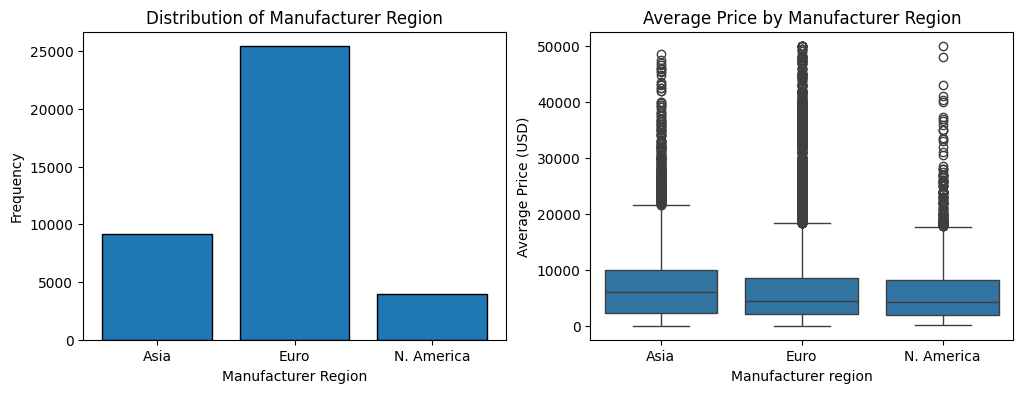

In [9]:
groupedby_region_count = cars.groupby("manufacturer_region").manufacturer_region.value_counts()


fig, ax = plt.subplots(1,2, figsize = (12,4))

ax[0].bar(groupedby_region_count.index,groupedby_region_count.values, edgecolor = "black" )
ax[0].set_xlabel("Manufacturer Region")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Distribution of Manufacturer Region")


sns.boxplot(x=cars["manufacturer_region"],y=cars["price_usd"])
plt.xlabel("Manufacturer region")
plt.ylabel("Average Price (USD)")
plt.title("Average Price by Manufacturer Region");

### 1.4.2 - Feature Addition (Vehicle Class)

In the automotive industry, manufacturers can frequently be stratified according to the vehicle types they specialize in, with a particular emphasis on pricing tiers. This classification allows us to augment our data set by introducing a categorical feature that distinguishes cars into distinct segments, such as **budget**, **economy**, or **luxury**. By incorporating this feature, Vladimir  can gain a more nuanced understanding of market dynamics and consumer preferences, thereby enabling more targeted analyses and strategic decision-making within the competitive landscape of the automotive sector.

Let's look at the mean price of each manufacturer

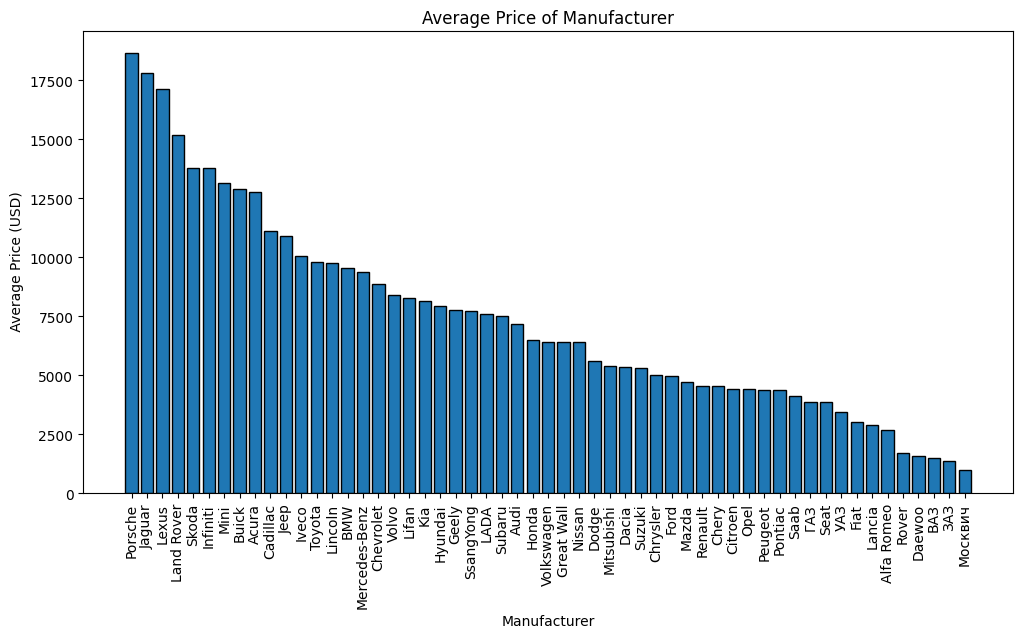

In [10]:
# Group by manufacturer and find it's mean price
manufacturer_mean_price = cars.groupby("manufacturer_name").price_usd.mean().sort_values(ascending = False)

# Plot the mean price of each manufacturer
fig, ax = plt.subplots(figsize = (12,6))
ax.bar(manufacturer_mean_price.index, manufacturer_mean_price.values, edgecolor= "black")

plt.xticks(rotation = 90)
plt.xlabel("Manufacturer")
plt.ylabel(" Average Price (USD)")
plt.title("Average Price of Manufacturer")

plt.show()

#### Create "vehicle_class" feature

*** IMPORTANT NOTE *** <br>
Using average price to determine the vehicle class does have its flaws. There are a number of factors which could alter the average price of a **used** vehicle (high milage, older model,etc) when intuition tells us the manufacturer should not be categorized as such. However, I am fairly happy with the bar graph above since it does an decent job placing certain manufacturer brands where we expect them to be

With this assumption we will categorize manufacturers as follows:
- \\$10,000 avg. price and above as "luxury"
- \\$5000 to \\$9,999 avg. price as "economy"
-  \\$4,999 avg. price and below as "budget"




In [11]:
manufacturer_mean_price = cars.groupby("manufacturer_name").price_usd.mean().sort_values(ascending = False)

# Create an empty list
list_of_class =[]

# Create a for loop which compares the avg price and adds label accoriding to criteria below
def car_to_class(my_list):
    for i in range(0,len(my_list)):
        if manufacturer_mean_price.loc[my_list.manufacturer_name.iloc[i]] >= 10000:
            list_of_class.append("luxury")
        elif manufacturer_mean_price.loc[my_list.manufacturer_name.iloc[i]] >= 5000 and manufacturer_mean_price.loc[my_list.manufacturer_name.iloc[i]] < 10000:
            list_of_class.append("economy")
        else: 
            list_of_class.append("budget")
    return list_of_class
            
# Add "list_of_class" to cars DF as column
cars["vehicle_class"] = car_to_class(cars)


#### Visualization of "vehicle_class"

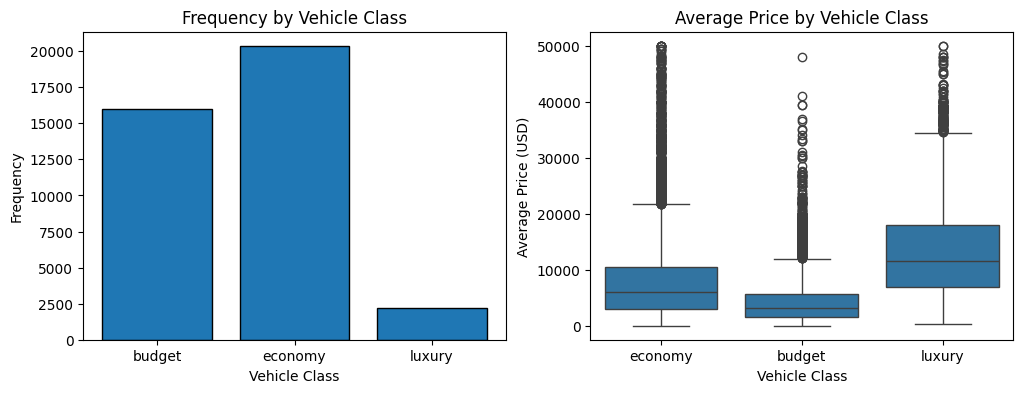

In [12]:
fig, ax = plt.subplots(1,2,figsize= (12,4))
groupby_vclass = cars.groupby("vehicle_class").vehicle_class.count()

plt.subplot(1,2,1)
plt.bar(groupby_vclass.index, groupby_vclass.values, edgecolor = "black")
plt.xlabel("Vehicle Class")
plt.ylabel("Frequency")
plt.title("Frequency by Vehicle Class")

plt.subplot(1,2,2)
sns.boxplot(x = cars.vehicle_class, y = cars.price_usd)
plt.xlabel("Vehicle Class")
plt.ylabel("Average Price (USD)")
plt.title("Average Price by Vehicle Class");

### 1.5 - Further Data Analysis (Sales Breakdown of the Used Car Market)

Let's deconstruct the sales figures of the used car market based on features within the dataset 

### 1.5.1 Sales by Model Year

*** IMPORTANT NOTE***
<br>Recall that this is **not a time series**. Instead, each data point represents the sale of a vehicle in 2019 and the "year_produced" variable corresponds to the model year of the car

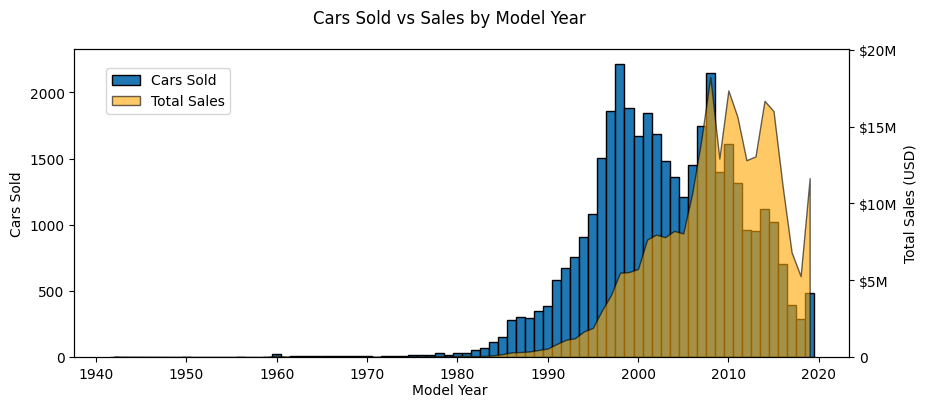

In [13]:
sales = cars.groupby("year_produced").price_usd.sum()
units_sold= cars.groupby("year_produced").year_produced.count()
 

fig, ax1 = plt.subplots(figsize = (10,4))
fig.suptitle("Cars Sold vs Sales by Model Year")
fig.supxlabel("Model Year",size=10)
ax2 = ax1.twinx()


ax1.bar(sales.index, units_sold.values, edgecolor = "black", width = 1, label = "Cars Sold")
ax1.set_ylabel("Cars Sold")

ax2.fill_between(sales.index,sales.values.astype(int), color = "orange", alpha = 0.6, edgecolor = "black", label = "Total Sales")
ax2.set_ylim([0,(max(sales.values)+(max(sales.values) * 0.1))])
ax2.set_yticks([0,5000000,10000000,15000000,20000000],["0","$5M", "$10M","$15M","$20M"])
ax2.set_ylabel("Total Sales (USD)")

fig.legend(bbox_to_anchor=(0.15,0.85), loc = "upper left");

From the data set we can note the following:
- There are many vehicles sold before 2005 but correspond to a low portion of total sales
- There are relativley fewer cars sold after 2005 but correspond to a large portion of total sales
- There is a sharp uptick in sales in 2019. Further analysis reveals these are cars labeled "new" within the data set

### 1.5.2 - Sales by "manufacturer_region" and "vehicle_class"

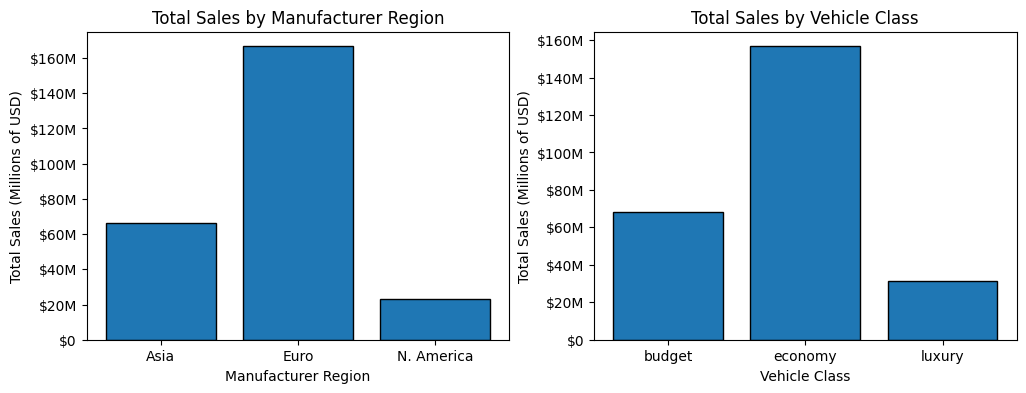

In [14]:

sales_by_region = cars.groupby("manufacturer_region").price_usd.sum()
sales_by_class = cars.groupby("vehicle_class").price_usd.sum()

fig , axs = plt.subplots(1,2, figsize= (12,4))

axs[0].bar(sales_by_region.index, sales_by_region.values, edgecolor= "black")
axs[0].set_title("Total Sales by Manufacturer Region")
axs[0].set_xlabel("Manufacturer Region")
axs[0].set_ylabel("Total Sales (Millions of USD)")
axs[0].set_yticks([0, 20000000, 40000000, 60000000, 80000000, 100000000, 120000000, 140000000, 160000000],
           ["$0", "$20M", "$40M", "$60M", "$80M", "$100M", "$120M", "$140M", "$160M"])


axs[1].bar(sales_by_class.index, sales_by_class.values, edgecolor = "black")
axs[1].set_title("Total Sales by Vehicle Class")
axs[1].set_xlabel("Vehicle Class")
axs[1].set_ylabel("Total Sales (Millions of USD)")
axs[1].set_yticks([0, 20000000, 40000000, 60000000, 80000000, 100000000, 120000000, 140000000, 160000000],
           ["$0", "$20M", "$40M", "$60M", "$80M", "$100M", "$120M", "$140M", "$160M"]);


### 1.5.3 - Sales by Body Type

Let's look at the total sales of each body type within the used car market

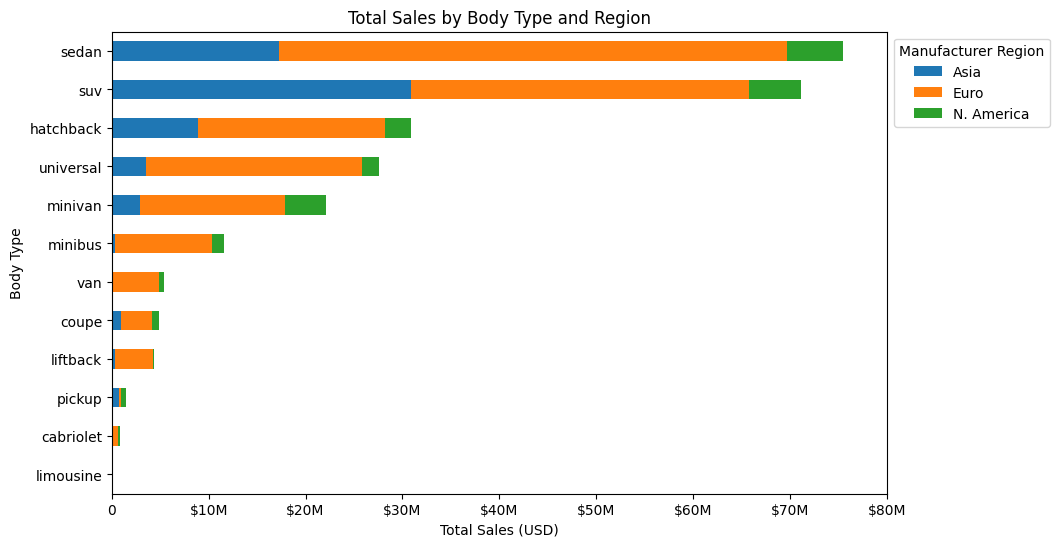

In [15]:

# Group by body_type and manufacturer_region
df_bodyregion=cars.groupby(["body_type", "manufacturer_region"]).price_usd.sum()

# Unstack the window to make the data more workable
df_bodyregion=df_bodyregion.unstack()

# Add a column which sums across a row to sort by Total Sales
df_bodyregion["row_sum"] = df_bodyregion.sum(axis=1)
df_bodyregion = df_bodyregion.sort_values(by ="row_sum", ascending = True)
df_bodyregion = df_bodyregion.drop("row_sum", axis =1)

# Create stacked bar chart
ax1 =df_bodyregion.plot(kind='barh', stacked=True, figsize=(10, 6))

# Set labels and title
ax1.set_xlabel("Total Sales (USD)")
ax1.set_ylabel("Body Type")
ax1.set_xticks([0,10000000,20000000,30000000,40000000,50000000,60000000,70000000,80000000],
               ["0","$10M","$20M","$30M","$40M","$50M","$60M","$70M","$80M"])
ax1.set_title("Total Sales by Body Type and Region")

# Show legend
ax1.legend(title='Manufacturer Region', loc='upper left', bbox_to_anchor=(1, 1));


A quick glimpse at this visual indicates Vladimir should consider selling sedans and SUVs. Also, although asian sedans aren't as popular as european sedans, asian SUVs seem to be just as popular as European ones

### 1.5.4 - Manufacturer Total Sales by Number of Cars Sold

Let's compare the total sales and number of cars sold for each manufacturer

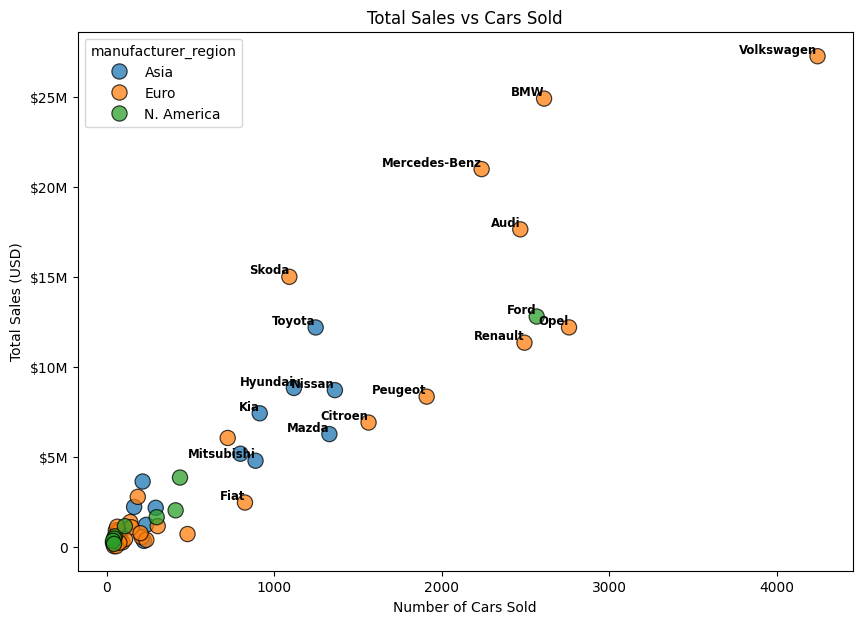

In [84]:
# Group by manufacturer_region and manufacturer_name. Aggregate over price and count
manufacturer_df = cars.groupby(["manufacturer_region", "manufacturer_name"]).price_usd.agg([sum,len])

#Tidy up the new DF
manufacturer_df = manufacturer_df.reset_index()
manufacturer_df["total_sales"] = manufacturer_df["sum"]
manufacturer_df["cars_sold"] = manufacturer_df["len"]
manufacturer_df = manufacturer_df.drop(["sum", "len"], axis = 1)


# Create a scatterplot. Use Seaborn.scatterplot since it's more user friendly 
plt.figure(figsize=(10,7))
sns.scatterplot(x="cars_sold", y="total_sales", hue = "manufacturer_region",data = manufacturer_df, s=120, edgecolor = "black", alpha = 0.75)
plt.title("Total Sales vs Cars Sold")
plt.xlabel("Number of Cars Sold")
plt.ylabel("Total Sales (USD)")
plt.yticks([0,5000000,10000000,15000000,20000000,25000000],["0","$5M","$10M","$15M","$20M","$25M"])

# Add annotations for manufacturer_name 
for index, row in manufacturer_df.iterrows():
    if row["cars_sold"] > 800:
        plt.text(row["cars_sold"], row["total_sales"], row["manufacturer_name"],horizontalalignment = "right",
                 verticalalignment = "bottom",size = "small", weight = "bold")
    continue

This visual helps us understand which manufacturers are abundent within the Belarusian used car martket and which brands dominate the market space

In [114]:
cars_2005 = cars.loc[(cars.year_produced >= 2006) & (cars.manufacturer_region.isin(["Asia", "Euro"])) & (cars.body_type.isin(["suv","sedan"]))]

print(len(cars_2005)/len(cars))

print(cars_2005.price_usd.sum()/cars.price_usd.sum())

0.19729568399470557
0.406877893233355


(8128, 18)